In questo laboratorio, vedremo alcuni metodi di domain adaptation basati su deep learning.

Imposiamo i seed per riproducilibilità:

In [1]:
import torch
import random
import numpy as np
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pytorch_lightning as pl
import itertools
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score
from torch.optim import SGD

import lib

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

NUM_EPOCHS = 5
NUM_GPUS = 0


# 1 Image to Image translation con CycleGAN - Pixel-level Domain Adaptation

Il primo metodo di domain adaptation che vediamo in questo laboratorio è pensato per lavorare su immagini ed effettua l'adattamento al livello dei pixel. L'approccio che vediamo qui assume che siano disponibili delle immagini appartenenti al dominio A e delle immagini appartenenti al dominio B, ma che tali esempi siano non accoppiati. L'approccio che vedremo si chiama CycleGAN e si basa sul principio della cycle consistency loss. Si faccia riferimento a https://arxiv.org/abs/1703.10593 per la pubblicazione ufficiale.

L'obiettivo di CycleGAN è quello di trasformare una immagine appartentente a un dominio di partenza in una immagine dal lo stesso contenuto, ma che possa essere "scambiata" per una immagine appartenente a un dominio di destinazione. Per fare ciò, l'algoritmo trasformerà l'immagine cambiandone solo lo stile. Esempi di trasformazioni tra due domini sono mostrati di seguito:
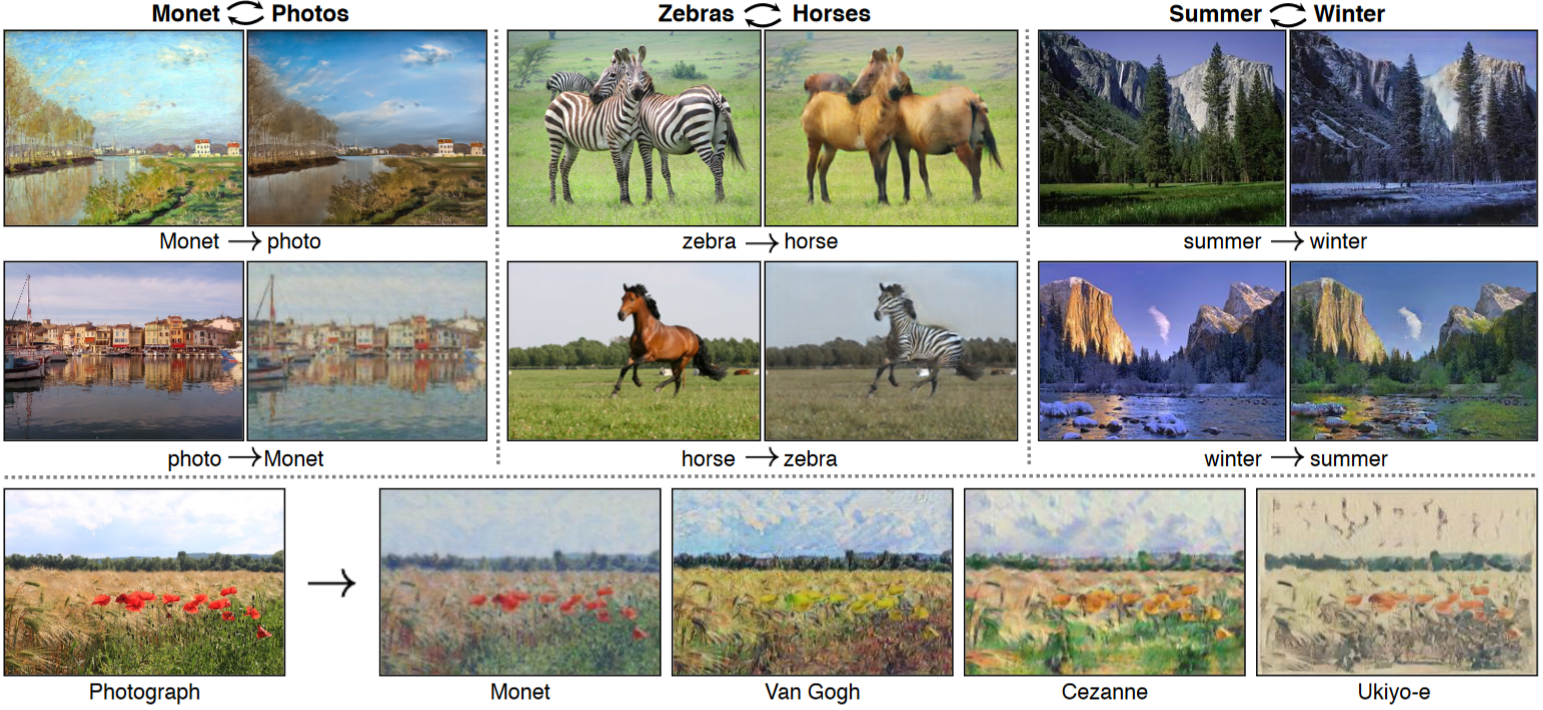

Il modello che effettuerà la trasformazione si basa su due insiemi di immagini appartenenti ai due domini A e B. Si assumerà che le immagini sono "disaccoppiate", il che vuol dire che a una data immagine di A non corrisponderà una specifica immagine di B in termini di contenuto. 
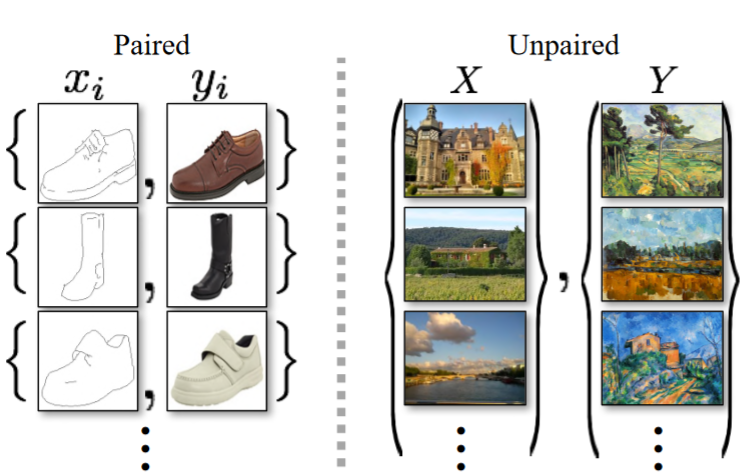

Per effettuare il training sotto queste condizioni, vengono usati due moduli, uno che trasforma le immagini dal dominio A al dominio B e uno che trasforma le immagini dal dominio B al dominio A. Questi due moduli sono detti "generatori" in analogia con le GAN. Vengono dunque usati due discriminatori per assicurarci che le immagini generate siano indistinguibili da quelle effettivamente appartenenti ai due domini. Per gestire il caso di immagini non accoppiati, viene utilizzata la cycle consistency loss che incoraggia il modello a far si che una immagine trasformata da A a B e poi nuovamente in A sia coerente con l'immagine di partenza.
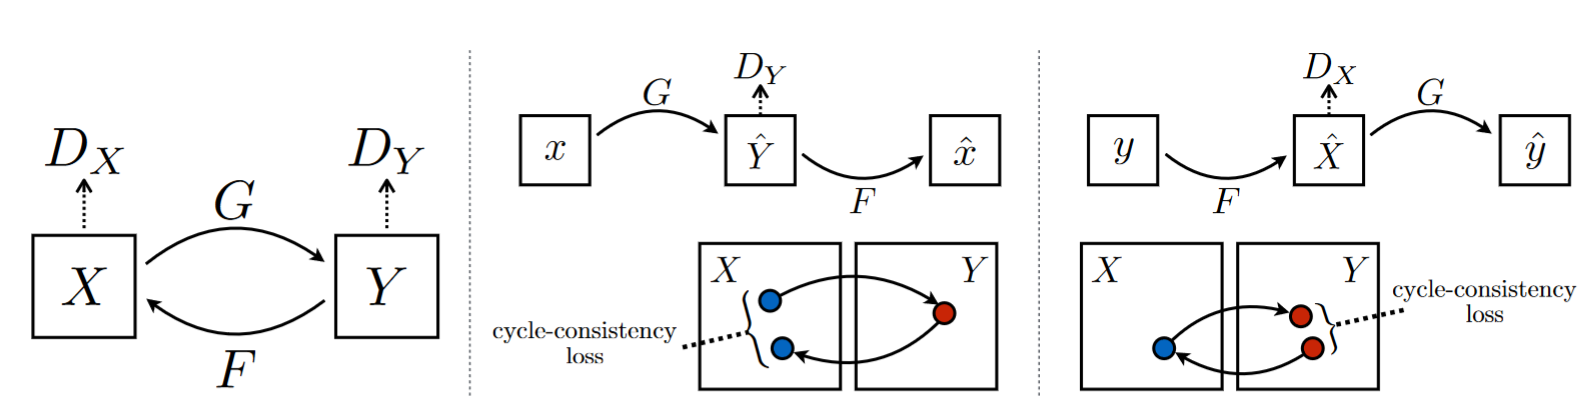

In questo laboratorio, faremo riferimento all'implementazione in PyTorch disponibile al link che segue, ma ne riproporremo una implementazione basata su PyTorch Lightning: https://github.com/aitorzip/PyTorch-CycleGAN.

In [9]:
!curl https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/grumpifycat.zip -o 'grumpifycat.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.4M  100 19.4M    0     0   555k      0  0:00:35  0:00:35 --:--:-- 1234k8k      0  0:00:47  0:00:12  0:00:35  546k  0:00:43  0:00:31  0:00:12  262k


In [ ]:
!unzip grumpifycat.zip

Per caricare il dataset ed accedere alle immagini, definiamo una classe `ImageDataset`:

Possiamo adesso definire l'oggetto dataset e caricare come segue:

In [2]:
dset = lib.ImageDataset('grumpifycat')

Visualizzimo quindi una coppia di immagini:

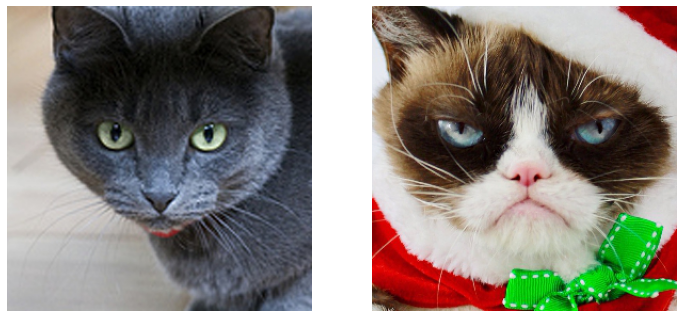

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(np.array(dset[0][0]))
plt.axis('off')
plt.subplot(122)
plt.imshow(np.array(dset[0][1]))
plt.axis('off')
plt.show()

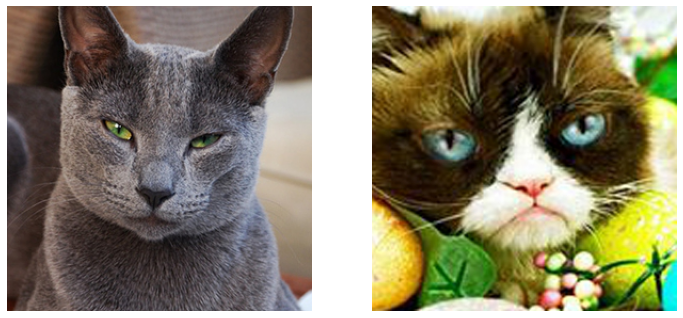

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(np.array(dset[300][0]))
plt.axis('off')
plt.subplot(122)
plt.imshow(np.array(dset[300][1]))
plt.axis('off')
plt.show()

## 1.2 Implementazione
Definiamo i modelli che utilizzeremo per costruire la rete CycleGAN, ovvero il generatore e il discriminatore. Iniziamo definendo il ResidualBlock, alla base del generatore:

Possiamo analizzare le dimensioni delle feature map intermedie del modello mediante la libreria `torchsummary`.

Vediamo quali sono le dimensioni intermedie delle feature map con un input di dimensioni $3 \times 224 \times 224$:

In [3]:
gen = lib.Generator(3,3)
summary(gen, (3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 3, 224, 224]         --
|    └─ReflectionPad2d: 2-1                   [-1, 3, 230, 230]         --
|    └─Conv2d: 2-2                            [-1, 64, 224, 224]        9,472
|    └─InstanceNorm2d: 2-3                    [-1, 64, 224, 224]        --
|    └─ReLU: 2-4                              [-1, 64, 224, 224]        --
|    └─Conv2d: 2-5                            [-1, 128, 112, 112]       73,856
|    └─InstanceNorm2d: 2-6                    [-1, 128, 112, 112]       --
|    └─ReLU: 2-7                              [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                            [-1, 256, 56, 56]         295,168
|    └─InstanceNorm2d: 2-9                    [-1, 256, 56, 56]         --
|    └─ReLU: 2-10                             [-1, 256, 56, 56]         --
|    └─ResidualBlock: 2-11                    [-1, 256, 56, 56]         --
|    |  

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 3, 224, 224]         --
|    └─ReflectionPad2d: 2-1                   [-1, 3, 230, 230]         --
|    └─Conv2d: 2-2                            [-1, 64, 224, 224]        9,472
|    └─InstanceNorm2d: 2-3                    [-1, 64, 224, 224]        --
|    └─ReLU: 2-4                              [-1, 64, 224, 224]        --
|    └─Conv2d: 2-5                            [-1, 128, 112, 112]       73,856
|    └─InstanceNorm2d: 2-6                    [-1, 128, 112, 112]       --
|    └─ReLU: 2-7                              [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                            [-1, 256, 56, 56]         295,168
|    └─InstanceNorm2d: 2-9                    [-1, 256, 56, 56]         --
|    └─ReLU: 2-10                             [-1, 256, 56, 56]         --
|    └─ResidualBlock: 2-11                    [-1, 256, 56, 56]         --
|    |  

Come possiamo vedere dal summary sopra, il modello è composto di due parti: un encoder con diversi residual block e un decoder con alcuni blocchi di convoluzioni. L'encoder effettua downsampling dell'immagine, mentre il decoder effettua un upsampling per restituire una immagine delle stesse dimensioni dell'input.

Possiamo visualizzare anche in questo caso le dimensioni delle mappe intermedie con `torchsummary`:

In [6]:
disc = lib.Discriminator(3)
summary(disc, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 26, 26]           --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        3,136
|    └─LeakyReLU: 2-2                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-3                       [-1, 128, 56, 56]         131,200
|    └─InstanceNorm2d: 2-4               [-1, 128, 56, 56]         --
|    └─LeakyReLU: 2-5                    [-1, 128, 56, 56]         --
|    └─Conv2d: 2-6                       [-1, 256, 28, 28]         524,544
|    └─InstanceNorm2d: 2-7               [-1, 256, 28, 28]         --
|    └─LeakyReLU: 2-8                    [-1, 256, 28, 28]         --
|    └─Conv2d: 2-9                       [-1, 512, 27, 27]         2,097,664
|    └─InstanceNorm2d: 2-10              [-1, 512, 27, 27]         --
|    └─LeakyReLU: 2-11                   [-1, 512, 27, 27]         --
|    └─Conv2d: 2-12                      [-1, 1, 26, 26]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 26, 26]           --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        3,136
|    └─LeakyReLU: 2-2                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-3                       [-1, 128, 56, 56]         131,200
|    └─InstanceNorm2d: 2-4               [-1, 128, 56, 56]         --
|    └─LeakyReLU: 2-5                    [-1, 128, 56, 56]         --
|    └─Conv2d: 2-6                       [-1, 256, 28, 28]         524,544
|    └─InstanceNorm2d: 2-7               [-1, 256, 28, 28]         --
|    └─LeakyReLU: 2-8                    [-1, 256, 28, 28]         --
|    └─Conv2d: 2-9                       [-1, 512, 27, 27]         2,097,664
|    └─InstanceNorm2d: 2-10              [-1, 512, 27, 27]         --
|    └─LeakyReLU: 2-11                   [-1, 512, 27, 27]         --
|    └─Conv2d: 2-12                      [-1, 1, 26, 26]         

Il discriminatore riduce la dimensionalità dell'input aumentando il numero di mappe. Notiamo comunque che l'output è un  numero reale (il logit):

In [7]:
disc(torch.zeros(1,3,224,224)).shape

torch.Size([1, 1])

Una volta definito il modulo, effettuiamo il training con Lightning:

In [14]:
cycle_gan = lib.CycleGAN(data_root='grumpifycat')

logger = TensorBoardLogger("tb_logs", name="grumpifycat_cyclegan")
trainer = pl.Trainer(gpus=NUM_GPUS, logger=logger, max_epochs=1)

trainer.fit(cycle_gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name               | Type          | Params
-----------------------------------------------------
0 | netG_A2B           | Generator     | 11.4 M
1 | netG_B2A           | Generator     | 11.4 M
2 | netD_A             | Discriminator | 2.8 M 
3 | netD_B             | Discriminator | 2.8 M 
4 | criterion_GAN      | MSELoss       | 0     
5 | criterion_cycle    | L1Loss        | 0     
6 | criterion_identity | L1Loss        | 0     
-----------------------------------------------------
28.3 M    Trainable params
0         Non-trainable params
28.3 M    Total params
113.143   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/214 [00:00<?, ?it/s] 

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

## 1.3 Risultati ----- DA QUI
Notiamo che PyTorch Lightning ha salvato in automatico l'ultimo checkpoint del modello in `tb_logs/grumpifycat_cyclegan/version_1/checkpoints/`. Questo checkpoint può essere caricato come segue:

In [33]:
mod = lib.CycleGAN.load_from_checkpoint('tb_logs/grumpifycat_cyclegan/version_1/checkpoints/epoch=199-step=42799.ckpt')

Vediamo adesso di stampare alcuni esempi di traduzione da un dominio all'altro. Iniziamo recuperando il dataset di training:

In [34]:
dset = mod.train_dataloader().dataset

Adesso definiamo una funzione per effettuare la traduzione A2B e quella B2A per verificare che l'identità è rispettata:

In [35]:
def print_example_A2B(i):
    image_in = dset[i][0]
    a2b = mod.netG_A2B(image_in.unsqueeze(0))
    a2b2a = mod.netG_B2A(a2b)

    image_in = image_in.detach().numpy().transpose(1,2,0)
    image_in-=image_in.min()
    image_in/=image_in.max()

    a2b = a2b.squeeze().detach().numpy().transpose(1,2,0)
    a2b-=a2b.min()
    a2b/=a2b.max()
    
    a2b2a = a2b2a.squeeze().detach().numpy().transpose(1,2,0)
    a2b2a-=a2b2a.min()
    a2b2a/=a2b2a.max()

    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(image_in)
    plt.title('A')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(a2b)
    plt.title('A2B')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(a2b2a)
    plt.title('A2B2A')
    plt.axis('off')

Visualizziamo alcuni esempi di trasformazione:

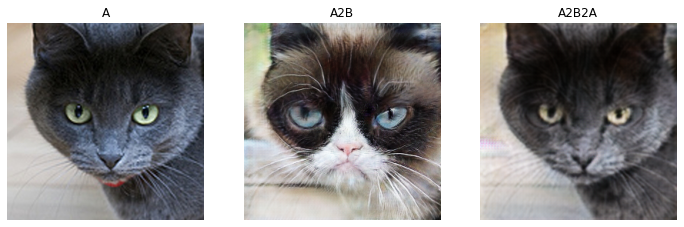

In [36]:
print_example_A2B(0)

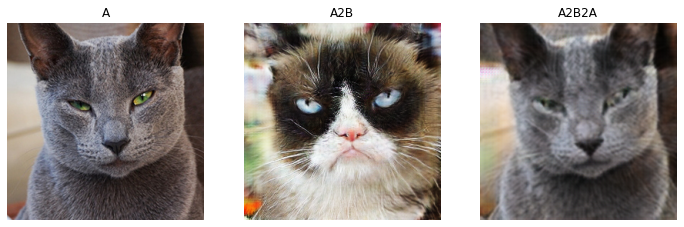

In [37]:
print_example_A2B(300)

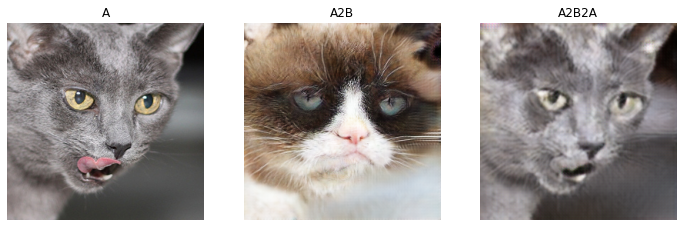

In [38]:
print_example_A2B(128)

Si noti che l'implementazione qui fornita è stata riscritta per migliorarne la leggibilità e dunque essa non è quella ufficiale. E' consigliabile usare l'implementazione ufficiale per essere sicuri di avere i risultati più in linea con la pubblicazione scientifica: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.

# 2 Feature-level Domain Adaptation

Vedremo adesso degli altri esempi di domain adaptation. In questo caso l'adattamento non viene fatto al livello dei pixel, ma al livello delle feature estratte dal modello. Considereremo in particolare il problema della classificazione delle immagini appartenenti a due domini: uno **sorgente** e uno **target**. Le immagini del dominio **sorgente** sono etichettate, mentre quelle del dominio **target** non sono etichettate. Entrambi i domini condividono lo stesso spazio delle etichette. L'obiettivo è quello di allenare un modello capace di fare training sulle immagini etichettate del dominio sorgente e su quelle non etichettate del dominio target e funzionare bene in fase di test sulle immagini di entrambi i domini. Questo setup è detto **unsupervised domain adaptation** in quanto le immagini del dominio target sono non etichettate e dunque l'adattamento è **non supervisionato**.

Definiamo un numero di epoche per il quale fare training:

In [39]:
NUM_EPOCHS=50

## 2.1 Dati

Considereremo due dataset di immagini di cifre comprese tra 0 e 9. Uno dei due è il classico MNIST, mentre l'altro è MNISTM, una versione di MNIST in cui le cifre sono incollate su sfondi colorati.

Utilizzeremo l'implementazione disponibile a questo link (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cogan/mnistm.py) per caricare il dataset:

In [41]:
mnistm_train = lib.MNISTM(root='data', train=True, download=True)

Vediamo qualche esempio:

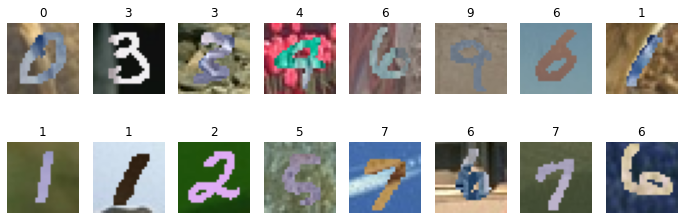

In [42]:
j=1
plt.figure(figsize=(12,4))
for i in np.random.permutation(len(mnistm_train))[:16]:
    plt.subplot(2,8,j)
    plt.imshow(np.array(mnistm_train[i][0]))
    plt.title(mnistm_train[i][1].item())
    plt.axis('off')
    j+=1
plt.show()

Confrontiamo gli esempi con il solito MNIST:

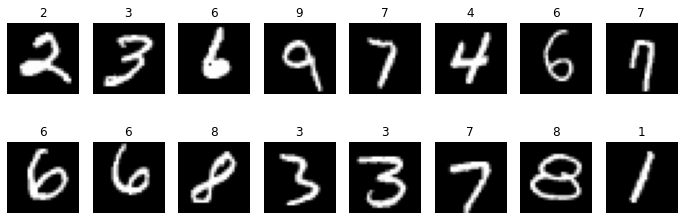

In [43]:
mnist_train = MNIST(root = 'data',train=True, download=True)
j=1
plt.figure(figsize=(12,4))
for i in np.random.permutation(len(mnist_train))[:16]:
    plt.subplot(2,8,j)
    plt.imshow(np.array(mnist_train[i][0]), cmap='gray')
    plt.title(mnist_train[i][1])
    plt.axis('off')
    j+=1
plt.show()

Definiamo adesso dataset e dataloader:

In [44]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

mnist_train = MNIST('data', train=True, transform=transform, download=True)
mnist_test = MNIST('data', train=False, transform=transform, download=True)

mnist_train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=8)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, num_workers=8)

mnistm_train = lib.MNISTM('data', train=True, transform=transform, download=True)
mnistm_test = lib.MNISTM('data', train=False, transform=transform, download=True)

mnistm_train_loader = DataLoader(mnistm_train, batch_size=256, shuffle=True, num_workers=8)
mnistm_test_loader = DataLoader(mnistm_test, batch_size=256, num_workers=8)

## 2.2 Modelli
Utilizzeremo come modello per la classificazione una semplice rete neurale basata su convoluzioni (lib):

Il modello definito sopra è progettato per lavorare con input di dimensione $3 \times 28 \times 28$. Vediamo le dimensioni intermedie delle feature map con la funzione `summary`:

In [46]:
mod = lib.Net().cuda()
summary(mod, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             760
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         MaxPool2d-5             [-1, 20, 4, 4]               0
         Dropout2d-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
Total params: 22,340
Trainable params: 22,340
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.09
Estimated Tot

### 2.2.1 Baseline
Inizieremo considerando un approccio baseline che consiste in allenare la rete su MNIST e fare test su SVHN. Definiamo un oggetto di Lightning per effettuare il training. Dato che abbiamo già definito il modello, applicheremo un paradigma diverso in cui il modulo di Lightning è considerato un "task" piuttosto che un modello:

Adesso definiamo e alleniamo il modello su MNIST:

In [ ]:
mnist_noadapt = lib.ClassificationTask(lib.Net())

logger = TensorBoardLogger("adaptation_logs", name="mnist_noadapt")

mnist_noadapt_trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=NUM_GPUS, logger=logger)
mnist_noadapt_trainer.fit(mnist_noadapt, mnist_train_loader, mnist_test_loader)

Dopo il training, le curve di performance saranno simili alle seguenti:

Validiamo adesso il modello sul validation set e memorizziamone il risultato:

In [50]:
mnist_noadapt_mnist_accuracy = mnist_noadapt_trainer.test(dataloaders=mnist_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.9898999929428101}
--------------------------------------------------------------------------------



Testiamo adesso il modello sul dominio target SVHN:

In [51]:
mnist_noadapt_mnistm_accuracy = mnist_noadapt_trainer.test(dataloaders=mnistm_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.6302000284194946}
--------------------------------------------------------------------------------



### 2.2.2 Oracolo
Consideriamo adesso il modello **oracolo**, ovvero lo stesso modello allenato sui dati di MNISTM etichettati. Si noti che queste performance non sono direttamente confrontabili con quegli degli altri modelli in quanto sono relative a modelli che fanno uso delle etichette del dominio target. E' tuttavia utile considerare i risultati del modello oracolo come una sorta di **upperbound** delle performance raggiungibili mediante domain adaptation.

In [ ]:
mnistm_noadapt = lib.ClassificationTask(lib.Net())

logger = TensorBoardLogger("adaptation_logs", name="mnistm_noadapt")

mnistm_noadapt_trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger)
mnistm_noadapt_trainer.fit(mnistm_noadapt, mnistm_train_loader, mnistm_test_loader)

Testiamo adesso il modello sul dominio target:

In [53]:
mnistm_noadapt_mnistm_accuracy = mnistm_noadapt_trainer.test(dataloaders=mnistm_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.9642999768257141}
--------------------------------------------------------------------------------



Per confrontare le varie performance, possiamo iniziare a costruire una tabella:

In [54]:
import pandas as pd
results = pd.DataFrame({
    'Model':['No Adaptation', 'Oracle'],
    'MNIST':[mnist_noadapt_mnist_accuracy, '-'],
    'MNISTM': [mnist_noadapt_mnistm_accuracy, mnistm_noadapt_mnistm_accuracy]
})
results

Model   MNIST  MNISTM
0  No Adaptation  0.9899  0.6302
1         Oracle       -  0.9643

### 2.2.3 Gradient Reversal layer

Vedremo come implementare il metodo di domain adaptation definito in questa pubblicazione scientifica: https://arxiv.org/abs/1409.7495. L'algoritmo segue lo schema mostrato nell'immagine che segue:

In pratica viene usato un modulo "feature extractor" (la backbone) per estrarre le feature dalle immagini di entrambi i domini. Un modulo "label predictor" viene dunque ustao per classificare le immagini del dominio A a partire dalle feature estratte. Un discriminatore viene usato per incoraggiare la backbone a estrarre feature che siano indipendenti rispetto al dominio (dunque i due domini saranno indistinguibili guardando solo le feature). A differenza delle GAN, il training non è effettuato in maniera alternata, ma viene utilizzato un **Gradient Reversal Layer (GLR)** per ottimizzare al contempo il discriminatore e il feature extractor.

In questo laboratorio, seguiremo l'implementazione fornita qui: https://github.com/jvanvugt/pytorch-domain-adaptation.
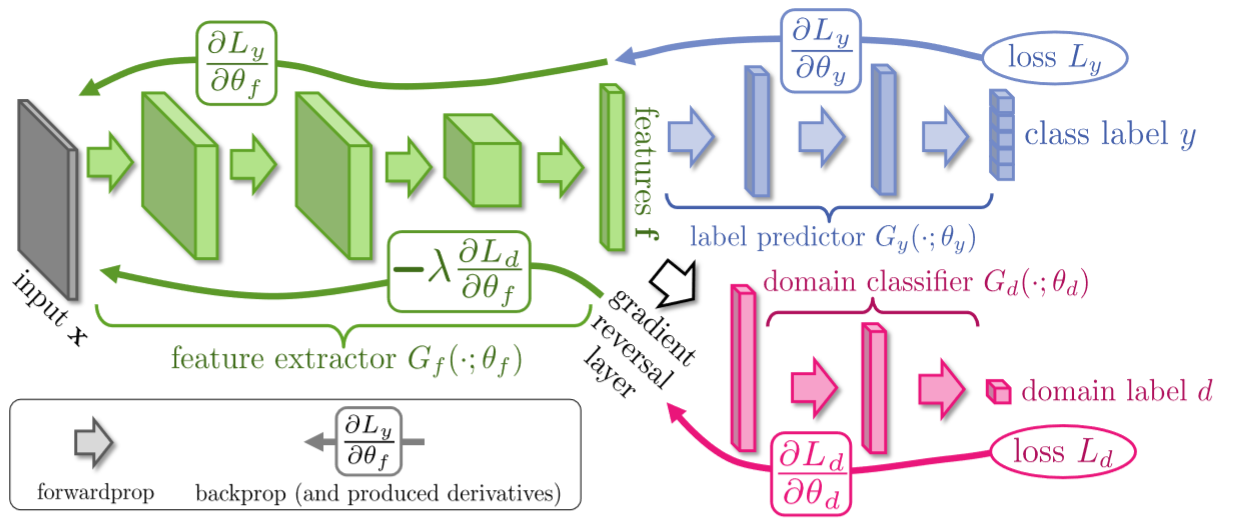

L'architetura che implementeremo si basa sul Gradinent Reversal Layer, le cui funzioni di forward e di backward sono definite come segue:

In [55]:
revgrad = lib.RevGrad.apply

Implementiamo adesso il modulo per il training basato su gradient reversal layer. Iniziamo definendo il discriminatore. Questo modulo prenderà in input la mappa di feature restituita dal feature extractor e predirà il dominio di appartenenza:

Analizziamo le dimensioni intermedie delle mappe di feature del discriminatore. Useremo come dimensione dell'input un vettore di $320$ elementi, che è la dimensione dell'output del feature extractor:

In [59]:
disc = lib.DiscriminatorGRL().cuda()
summary(disc, (320,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          16,050
              ReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 20]           1,020
              ReLU-4                   [-1, 20]               0
            Linear-5                    [-1, 1]              21
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


Durante il training, l'algoritmo dovrà prendere in input un batch di immagini appartenenti al dominio sorgente e un batch di immagini appartenenti al dominio target. Per semplificare questo tipo di caricamento, definiamo un oggetto `MultiDomainDataset` che carica coppie di immagini dei due domini:

Costruiamo il dataset multidominio mnist_mnistm che usa MNIST come dominio sorgente e MNISTM come dominio target:

In [61]:
mnist_mnistm_train = lib.MultiDomainDataset(mnist_train, mnistm_train)
mnist_mnistm_train_loader = lib.DataLoader(mnist_mnistm_train, shuffle=True, num_workers=8, batch_size=256)

Adesso effettuiamo il training. In fase di validation e test passeremo il dataset svhn in modo da poter monitorare la capacità del modello di generalizzare:

In [ ]:
mnist_grl = lib.DomainAdaptationGRLTask(lib.Net())

logger = TensorBoardLogger("adaptation_logs", name="mnist_grl")

mnist_grl_trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=NUM_GPUS, logger=logger)
mnist_grl_trainer.fit(mnist_grl, mnist_mnistm_train_loader, mnistm_test_loader)

Alla fine del training, i grafici di performance saranno simili ai seguenti:

Testiamo adesso il modello sul dominio target:

In [66]:
mnistm_grl_mnistm_accuracy = mnist_grl_trainer.test(dataloaders=mnistm_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.828499972820282}
--------------------------------------------------------------------------------



Testiamo anche sul dominio sorgente per completezza:

In [67]:
mnistm_grl_mnist_accuracy = mnist_grl_trainer.test(dataloaders=mnist_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.982200026512146}
--------------------------------------------------------------------------------



Confrontiamo le performance dei modelli visti finora:

In [68]:
results = pd.DataFrame({
    'Model':['No Adaptation', 'GRL', 'Oracle'],
    'MNIST':[mnist_noadapt_mnist_accuracy, mnistm_grl_mnist_accuracy, '-'],
    'MNISTM': [mnist_noadapt_mnistm_accuracy, mnistm_grl_mnistm_accuracy, mnistm_noadapt_mnistm_accuracy]
})
results

Model   MNIST  MNISTM
0  No Adaptation  0.9899  0.6302
1            GRL  0.9822  0.8285
2         Oracle       -  0.9643

### 2.2.4 Adversarial Domain Adaptation (ADDA)

Un altro metodo di feature-level domain adaptation di cui vedremo l'implementazione è ADDA (https://arxiv.org/pdf/1702.05464.pdf). Lo schema di funzionamento del metodo è descritto di seguito:
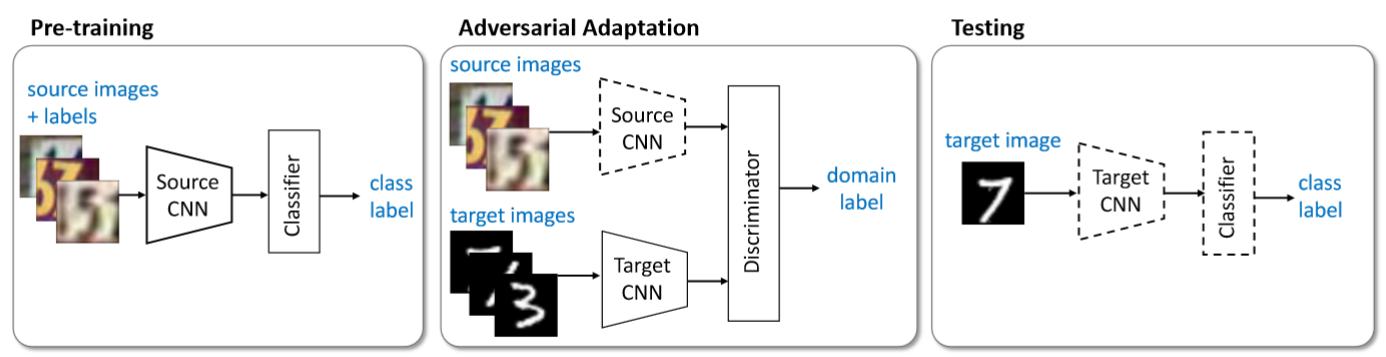

L'algoritmo funziona in tre fasi:

 * Pre-training: la rete viene allenata con le immagini ed etichette del dominio sorgente. Si tratta del modello di baseline allenato in precedenza.
 * Adversarial adaptation: in questo caso, viene utilizzato il princio delle GAN per effettuare un adattamento della rete. Più nello specifico, viene fatta una copia della rete di partenza e adattata mediante un discriminatore.
 * Testing: il modello target viene utilizzato per il test direttamente sulle immagini target.

Per gli esperimenti con questo modello utilizzeremo nuovamente la coppia di dataset MNIST-MNISTM.

La fase di pre-training è già stata effettuata in precedenza con il modello di baseline. Utilizzeremo gli stessi feature extractor e classificatore. Definiamo invece un discriminatore senza GRL (libreria):

Vediamo dunque come implementare il modulo di Lightning che effetta l'adversarial adaptation:

Procediamo ora con il training:

In [ ]:
mnist_adda = lib.ADDATask(mnist_noadapt.model)

logger = TensorBoardLogger("adaptation_logs", name="mnist_adda")

mnist_adda_trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger)
mnist_adda_trainer.fit(mnist_adda, mnist_mnistm_train_loader, mnistm_test_loader)

Le curve di performance dopo il training saranno simili alle seguenti:

Testiamo adesso il modello sul dominio target e sul dominio sorgente:

In [87]:
mnistm_adda_mnistm_accuracy = mnist_adda_trainer.test(dataloaders=mnistm_test_loader)[0]['test/accuracy']
mnistm_adda_mnist_accuracy = mnist_adda_trainer.test(dataloaders=mnist_test_loader)[0]['test/accuracy']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.8490999937057495}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': 0.9212999939918518}
--------------------------------------------------------------------------------



Confrontiamo le performance dei modelli allenati finora:

In [88]:
results = pd.DataFrame({
    'Model':['No Adaptation', 'GRL', 'ADDA', 'Oracle'],
    'MNIST':[mnist_noadapt_mnist_accuracy, mnistm_grl_mnist_accuracy, mnistm_adda_mnist_accuracy, '-'],
    'MNISTM': [mnist_noadapt_mnistm_accuracy, mnistm_grl_mnistm_accuracy, mnistm_adda_mnistm_accuracy, mnistm_noadapt_mnistm_accuracy]
})
results

Model   MNIST  MNISTM
0  No Adaptation  0.9899  0.6302
1            GRL  0.9822  0.8285
2           ADDA  0.9213  0.8491
3         Oracle       -  0.9643